# **Colouring images**

GANs try to model relationships/distribution between X and Y, for each class, Y. Given class Y, they can create features X that represent Y.

Two neural networks are used, competing with each other:
1. Generator: generates new inputs, such as, images.
2. Discriminator: examines these images and determines if they are real, or created by the generator.

GANs are more efficient understanding texture and symmetry, rather than complex geometry. For instance, it is easier to create photos of landscapes, rather than to create persons or dogs.

### 1. Get data

- MIT computational visual library dataset: coastal photos containing simple landscapes

### 2. Preprocess

- Choose image size (if not equal, resize with numpy)
- In many examples, images from RGB color values were transformed to LAB. LAB consists of a light sensitivity channel and two colour channels.

  - L channel: constains information for light sensitivity of a photo and is equivalent to a black and white version.
  - A channel: colour channel controlling the green-red tradeoff.
  - B channel: colour channel controlling blue-yellow tradeoff.

  ![](http://shutha.org/sites/default/files//uploads/3_Courses/3_Digital_Imaging/02%20LAB2b.jpg)

(Python Scikit-Image library)

The idea is to pass the L channel through the generator as the input, and output the new A and B colour channels. Once converted to LAB, normalization is needed, as the pixel values are an inefficient range for the model to work with. They can be scaled [-1, 1].


### 3. Model

First, generator and discriminator are created separately, and then connected so the generator can learn based on how well it fools the other model. 

- Generator: consists of an encoder and decoder. L will be the input to the generator as it is equivalent to a grayscale photo. Here it is performed a transpose convolution or deconvolution which allow to upsample the image size. The process is repeated until we are back at the original size, and then output the new image, the A and B channels.

- Discriminator: much simpler. This is a CNN that is used to predict whether the AB channels are real or fake. 





# Universal workflow

#### **1. Defining the problem and assembling a dataset**

  What will your input data be? what are you going to predict?
what type of problem are you facing?

  - binary classification
  - multiclass classification
  - regresion
  - clustering
  - ...

  Make a hypothesis: my X is able to predict y (you will validate it later)

El problema a resolver es crear un modelo capaz de convertir una imagen de blanco y negro a color. Para eso, se utiliza el modelo generador o *generative modeling*, exactamente, una Red Generativa Adversarial, RGA (o *Generative Adversarial Network, GAN*). Éste se refiere a un aprendizaje no supervisado de *machine learning*, que consiste en detectar y aprender patrones automaticamente en los datos de entrada, de modo que el modelo pueda ser usado para generar nuevos datos de salida que posiblemente podrían haber sido unas copias perfectas de los datos originales.

Las redes GAN son una manera de entrenar un modelo generador considerandolo como un problema supervisado con dos sub-modelos: el generador, que produce nuevos ejemplos, y el discriminador, que clasifica si los ejemplos son reales (originales) o falsos (generados). 

The two models are trained together in a zero-sum game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.


Generador: autoencoder

Discriminador: clasificador binario


#### **2. Choose a measure of success**
  - Accuracy?
  - Precision?
  - Recall?
  - AUROC?

#### **3. Deciding on an evaluation protocol**

Maintaining a hold-out validation set
  - way to go if you have plenty of data

doing K-fold cross-validation
  - if you have no enough data for hold-out

Iterated k-fold validation
  - in order to have highly accurate model on little data

#### **4. preparing your data (for DL)**
  - put data into tensors
  - data should be scaled -> [0,1], [-1,1]
  - if data is heterogeneous, Standardization should be performed.
  - (feature engineering)

#### **5. Developing a first model**
  - Goal: get a model that has “statistical power”: a small model that proves that the problem is doable

  - choices to be made:
    - Last-layer activation selection
    - loss function selection
    - optimization configuration (Adam, rmsprop)

#### **6. Scaling up: developing a model that overfits**
  - once we have a model that has “statistical power”, can we make it more powerful?
  - in order to find a model that is optimum and general, first we need to cross the border and make a model that overfits, in order to find the best model.
    - Add layers
    - make layers bigger
    - train for more epochs

#### **7. Regularizing your model**
  - Once we have an overfit model, add regularization:
    - Add dropout
    - Add batch-normalization
    - early-stopping
    - try different architectures: add/remove layers
    - add L1/L2 regularization

#### **8. Tune hyperparameters**
  - Make a hyperparameter tuning in order to find the best model
    - grid search
    - Keras hyperopt

#### **9. Validate final model!!!!!!!!!**










In [23]:
# imports
from tensorflow.keras.preprocessing import image
from glob import glob
from PIL import Image
from skimage import color
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from copy import deepcopy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose,AveragePooling2D, Concatenate

In [46]:
# read images and transform to the desired size
def read_img(file, size = (128,128)):
    img = image.load_img(file, target_size=size)
    img = image.img_to_array(img)
    return img


# converts all images to 128x128x3
def convert_img_size(file_paths):
    all_images_to_array = np.zeros((len(file_paths), 128, 128, 3), dtype='int64')
    for ind, i in enumerate(file_paths):
        img = read_img(i)
        all_images_to_array[ind] = img.astype('int64')
    print('All Images shape: {} size: {:,}'.format(all_images_to_array.shape, all_images_to_array.size))
    return all_images_to_array

In [47]:
#obtain filepaths and convert to the correct datatype and size
file_paths = glob('train/colour/*.jpg')
#X_train = np.array([np.array(cv2.resize(cv2.imread(f),None,fx=0.32, fy=0.32)) for f in file_paths])
X_train = []
for f in file_paths:
  img = cv2.imread(f)
  resized = np.array(cv2.resize(img,None,fx=0.32, fy=0.32))
  #b = np.array(resized)
  X_train.append(resized)
X_train = np.array(X_train)
X_train.shape

(10, 128, 128, 3)

In [48]:
X_train.shape

(10, 128, 128, 3)

In [49]:
# Input RGB channels in range 0-255
# Outputs L or AB channels in range -1 to 1
# Normalize

def rgb_to_lab(img, lchannel=False, abchannel=False):
    img = img / 255
    l = color.rgb2lab(img)[:,:,0]
    l = l / 50 - 1
    l = l[...,np.newaxis]

    ab = color.rgb2lab(img)[:,:,1:]
    ab = (ab + 128) / 255 * 2 - 1
    if lchannel:
      return l
    else: 
      return ab

# Input L or AB channels in range -1 to 1
# Outputs RGB channels in range 0-255
# Denormalize

def lab_to_rgb(img):
    new_img = np.zeros((128,128,3))
    for i in range(len(img)):
        for j in range(len(img[i])):
            pix = img[i,j]
            new_img[i,j] = [(pix[0] + 1) * 50,(pix[1] + 1) / 2 * 255 - 128,(pix[2] +1) / 2 * 255 - 128]
    new_img = color.lab2rgb(new_img) * 255
    new_img = new_img.astype('uint8')
    return new_img

In [50]:
# 
L = np.array([rgb_to_lab(image,lchannel=True)for image in X_train])
AB = np.array([rgb_to_lab(image,abchannel=True)for image in X_train])

In [51]:
AB.shape

(10, 128, 128, 2)

In [52]:
L_AB = (L, AB)

In [53]:
X_train_L, X_train_AB = (L, AB)

In [54]:
#X_test_L = deepcopy(X_train_L[:20])
#X_test_AB = deepcopy(X_train_AB[:20])
#X_train_L = X_train_L[20:]
#X_train_AB = X_train_AB[20:] ## 20 depending on our dataset size baby

In [55]:
X_test_L = X_train_L[:2]
X_test_AB = X_train_AB[:2]
X_train_L = X_train_L[2:]
X_train_AB = X_train_AB[2:]

In [56]:
val = np.array(X_test_L.shape[:2])
val.shape

(2,)

In [57]:
d_image_shape = (128,128,2)
g_image_shape = (128,128,1)

**Stride:** stride is the number of pixels shifts over the input matrix. It's a filter that modifies the amount of movement over the image.

stride = 2 --> so that the image is downsized

**Padding:** the feature that adds blank, or empty pixels to the frame of the image to allow for a minimized reduction of size in the output layer. It is a way of increasing the size of an image, to counteract the fact that stride reduces the size.

Padding = same --> Border elements are computed using zero padding. The output may be same or smaller than the input depending on the stride option.

Padding and stride are the foundational parameters of any convolutional neural network. 

https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [58]:
# Create generator in Keras
# Autoencoder
def generator():
  model = Sequential()

  # encoder
  # (3x3) filter size
  # 64 feature maps
  #model.add(Conv2D(64,(3,3),padding='same',strides=2, input_shape=g_image_shape)) #dont need pooling since stride=2 downsizes
  #model.add(BatchNormalization())
  #model.add(LeakyReLU(0.2))
  #128 x 128 --> size of feature maps

  # double the feature maps
  model.add(Conv2D(128, (3,3), padding='same',strides=2))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))
  #64 x 64

  model.add(Conv2D(256, (3,3),padding='same',strides=2))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))
  #32 x 32 

  model.add(Conv2D(512,(3,3),padding='same',strides=2))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))
  #16 x 16

  # decoder
  # deconvolution layers
  model.add(Conv2DTranspose(256,(3,3), strides=(2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #model.add(Conv2DTranspose(32,(3,3),strides=(2,2),padding='same'))
  #model.add(BatchNormalization())
  #model.add(Activation('relu'))

  # 2 output channels --> A and B channels
  model.add(Conv2D(2,(3,3),padding='same'))
  model.add(Activation('tanh'))

  l_channel = Input(shape=g_image_shape)
  image = model(l_channel)
  return Model(l_channel,image)

In [59]:
# Create a discriminator in Keras 
# Convolutional Neural Network (CNN)
# Predict whether AB channels are real or fake
def discriminator():
  model = Sequential()

  model.add(Conv2D(32,(3,3), padding='same',strides=2,input_shape=d_image_shape))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(64,(3,3),padding='same',strides=2))
  model.add(BatchNormalization())
  model.add(LeakyReLU(.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(3,3), padding='same', strides=2))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))     

  # Sigmoid --> predict the image is real or fake
  model.add(Flatten())
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  image = Input(shape=d_image_shape)
  validity = model(image)
  return Model(image,validity)

In [60]:
# Build the Discriminator
# First, the discriminator is initialized/created. 
# Then, link the generator's loss to 
discriminator = discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(lr=0.00008,beta_1=0.5,beta_2=0.999), 
                      metrics=['accuracy']) 

# Making the Discriminator untrainable so that the generator can learn from fixed gradient 
#discriminator.trainable = False
discriminator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 126497    
Total params: 126,497
Trainable params: 126,113
Non-trainable params: 384
_________________________________________________________________


In [61]:
# Build the Generator 
generator = generator()
  
# Defining the combined model of the Generator and the Discriminator 
l_channel = Input(shape=g_image_shape)
image = generator(l_channel)
 
valid = discriminator(image)
  
combined_network = Model(l_channel, valid) 
combined_network.compile(loss='binary_crossentropy', 
                         optimizer=Adam(lr=0.0001,beta_1=0.5,beta_2=0.999))

In [62]:
generator.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 128, 128, 2)       3031874   
Total params: 3,031,874
Trainable params: 3,029,186
Non-trainable params: 2,688
_________________________________________________________________


In [65]:
# Creates lists to log the losses and accuracy
gen_losses = []
disc_real_losses = []
disc_fake_losses=[] 
disc_acc = []

# Train the generator on a full set of 320 and the discriminator on a half set of 160 for each epoch
# Discriminator is given real and fake y's while generator is always given real y's
n = 10 # 320
y_train_fake = np.zeros([5,1]) # 160
y_train_real = np.ones([5,1]) # 160
y_gen = np.ones([8,1])

# Optional label smoothing
#y_train_real -= .1

# Pick batch size and number of epochs, number of epochs depends on the number of photos per epoch set above
num_epochs=15
batch_size=32

In [66]:
l = X_train_L[:8]
ab = X_train_AB[:5]
l.shape

(8, 128, 128, 1)

In [67]:
# Run and train until photos meet expectations (stop & restart model with tweaks if loss goes to 0 in discriminator)
# tqdm --> Decorate an iterable object, returning an iterator which acts exactly like the original iterable, 
         # but prints a dynamically updating progressbar every time a value is requested.
for epoch in tqdm(range(1,num_epochs+1)):
    # Shuffle L and AB channels then take a subset corresponding to each networks training size
    np.random.shuffle(X_train_L) ####################################################################################### shuffle??
    l = X_train_L[:8]
    np.random.shuffle(X_train_AB)
    ab = X_train_AB[:5] # 160
    
    # input for generator: L channel
    # output: fake images
    fake_images = generator.predict(l[:5], verbose=1) # 160
    # Train on Real AB channels
    d_loss_real = discriminator.fit(x=ab, y= y_train_real, batch_size=32,epochs=1,verbose=1) 
    disc_real_losses.append(d_loss_real.history['loss'][-1])
    
    # Train on fake AB channels
    d_loss_fake = discriminator.fit(x=fake_images,y=y_train_fake,batch_size=32,epochs=1,verbose=1)
    disc_fake_losses.append(d_loss_fake.history['loss'][-1])
    
    # Append the loss and accuracy and print loss
    disc_acc.append(d_loss_fake.history['accuracy'][-1])

    # Train the gan by producing AB channels from L
    g_loss = combined_network.fit(x=l, y=y_gen,validation_split=0.1,batch_size=32,epochs=1,verbose=1)  # validation split 10%
    
    # Append and print generator loss
    gen_losses.append(g_loss.history['loss'][-1])
   
    # Every 50 epochs it prints a generated photo and every 100 it saves the model under that epoch
    if epoch % 50 == 0:
        print('Reached epoch: ',epoch)
        #print(X_test_L[:1])
        pred = generator.predict(X_test_L[1].reshape(1,128,128,1))
        print(pred.shape)
        pred_reshap = pred.reshape(128,128,2)
        img2 = np.dstack((X_test_L[1],pred.reshape(128,128,2)))
        img = lab_to_rgb(img2)
        plt.imshow(img)
        plt.show()
        if epoch % 100 == 0:
              generator.save('/content/drive/My Drive/Colab Notebooks/POPBL2/generator_' + str(epoch)+ '_v3.h5')

  0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step - loss: 0.5500 - val_loss: 0.6855


  7%|▋         | 1/15 [00:12<02:56, 12.59s/it]

1/1 [==============================] - 0s 244ms/step - loss: 0.0346 - val_loss: 0.6751


 13%|█▎        | 2/15 [00:16<02:08,  9.87s/it]

1/1 [==============================] - 0s 183ms/step - loss: 0.0466 - val_loss: 0.6636


 20%|██        | 3/15 [00:19<01:35,  7.97s/it]

1/1 [==============================] - 0s 153ms/step - loss: 0.0027 - val_loss: 0.6518


 27%|██▋       | 4/15 [00:22<01:12,  6.57s/it]

1/1 [==============================] - 0s 158ms/step - loss: 0.0055 - val_loss: 0.6398


 33%|███▎      | 5/15 [00:26<00:56,  5.61s/it]

1/1 [==============================] - 0s 163ms/step - loss: 0.0021 - val_loss: 0.6309


 40%|████      | 6/15 [00:29<00:44,  4.90s/it]

1/1 [==============================] - 0s 190ms/step - loss: 0.0022 - val_loss: 0.6262


 47%|████▋     | 7/15 [00:32<00:35,  4.42s/it]

1/1 [==============================] - 0s 259ms/step - loss: 0.0028 - val_loss: 0.6210


 53%|█████▎    | 8/15 [00:36<00:29,  4.21s/it]

1/1 [==============================] - 0s 184ms/step - loss: 0.0015 - val_loss: 0.6190


 60%|██████    | 9/15 [00:40<00:23,  3.97s/it]

1/1 [==============================] - 0s 283ms/step - loss: 0.0040 - val_loss: 0.6178


 67%|██████▋   | 10/15 [00:44<00:20,  4.18s/it]

1/1 [==============================] - 0s 164ms/step - loss: 0.0026 - val_loss: 0.6189


 73%|███████▎  | 11/15 [00:48<00:15,  4.00s/it]

1/1 [==============================] - 0s 153ms/step - loss: 0.0035 - val_loss: 0.6226


 80%|████████  | 12/15 [00:51<00:11,  3.78s/it]

1/1 [==============================] - 0s 211ms/step - loss: 0.0046 - val_loss: 0.6257


 87%|████████▋ | 13/15 [00:55<00:07,  3.79s/it]

1/1 [==============================] - 0s 173ms/step - loss: 0.0019 - val_loss: 0.6071


 93%|█████████▎| 14/15 [00:58<00:03,  3.64s/it]

1/1 [==============================] - 0s 218ms/step - loss: 0.0017 - val_loss: 0.5978


100%|██████████| 15/15 [01:01<00:00,  4.13s/it]


In [ ]:
plt.plot(disc_acc)

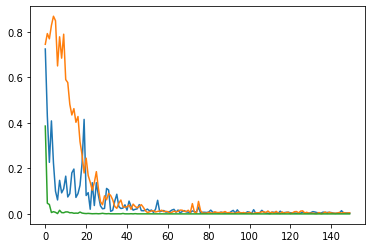

In [28]:
plt.plot(disc_real_losses, label='real_losses')
plt.plot(disc_fake_losses, label='fake_losses')
plt.plot(gen_losses, label='gen_losses')
plt.show()

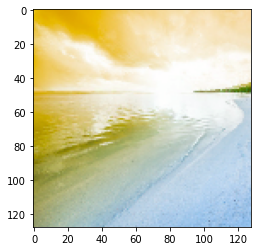

In [48]:
# Original image
original = lab_to_rgb(np.dstack((X_test_L[0],X_test_AB[0]))).astype('int64')
plt.imshow(original)

Load image

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img


# load the image
img = load_img('1.jpg')
generator = load_model('generator_100_v3.h5')

In [3]:
img.show()